In [ ]:
!pip install -U sentence-transformers

In [83]:
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import urllib.request
from tqdm import tqdm
import statistics
import requests
import json
import re
import os
import random
import time
random.seed(2)


In [7]:
url_GSM8K = 'https://raw.githubusercontent.com/openai/grade-school-math/master/grade_school_math/data/train.jsonl'

# выгружаем размеченные данные из GSM8K
data_GSM8K = urllib.request.urlopen(url_GSM8K).read().decode("utf-8").splitlines()

In [16]:
# подготавливаем список правильных решений-ответов ANSWERS
NUMBER_OF_TEST_PROBLEMS = 100
ANSWERS = []
for i,problem in enumerate(data_GSM8K):
  thoughts = json.loads(data_GSM8K[i])["answer"]
  ANSWERS.append([thoughts[thoughts.find('#### ') + len('#### '):], thoughts])

In [29]:
# ищем в сгененированном решении ответ: попробуем найти выражение вида "answer * ."
# если такое вырежние не нашлось, принимаем за ответ число за последним знаком "="
# иначе просто возьмём последнее сгенерированное число

def Answer_search(string):
    pattern  = r"answer[^.]*\s+([0-9]+)[^.]*\."
    match_re = re.search(pattern, string)
    if match_re:
      return int(match_re.group(1))

    pattern  = r"=(\s*\d+)\b"
    match_re = re.findall(pattern, string)
    if match_re:
      return int(match_re[-1])

    pattern  = r'\d+'
    match_re = re.findall(pattern, string)
    if match_re:
      return int(match_re[-1])

    return None
    


#Первый способ генерации (фиксированные примеры в prompts)

In [156]:
# из текстовых файлов достаём рассуждения и ответы
with open(f'/content/greedy.txt', 'r') as f:
  GREEDY_THOUGHTS = f.read().replace('\n', '').split("#")[:-1]
  
GREEDY_ANSWERS = [Answer_search(thought) for thought in GREEDY_THOUGHTS]


GENERATED_THOUGHTS = []
for i in range(NUMBER_OF_TEST_PROBLEMS):
  with open(f'/content/{i}_ensemble.txt', 'r') as f:
    lines = f.read().replace('\n', '')
    lines = lines.split("#")[:-1]
    for i in range(len(lines)):
      if "question:" in lines[i]:
        index    = lines[i].index("question:")
        lines[i] = lines[i][:index]

    GENERATED_THOUGHTS.append(lines)


GENERATED_ANSWERS = []
for thoughs in GENERATED_THOUGHTS:
  GENERATED_ANSWERS.append([Answer_search(thought) for thought in thoughts]) 


In [232]:
# проверка совпадения с настоящими ответами
def matching(answers):
  return sum([1 for i in range(NUMBER_OF_TEST_PROBLEMS) if answers[i] == int(ANSWERS[i][0])])

In [234]:
# проверим, сколько раз greedy даёт правильный ответ
matching(GREEDY_ANSWERS)

5

Для ансамблированного CoT попробуем выбрать ответ как моду сгенерированных ответов:

In [235]:
# создадим словарь самых часто встречающихся ответов и их индексов
def Most_popular_answer(lst):
    if len(lst) == 1:
        return {lst[0]: [0]}

    count_dict = defaultdict(list)
    for i, x in enumerate(lst):
        count_dict[x].append(i)

    max_count = max(len(indices) for indices in count_dict.values())

    result_dict = {}
    for x, indices in count_dict.items():
        if len(indices) == max_count:
            result_dict[x] = indices

    return result_dict

In [239]:
# загружаем модель Sentence-BERT 
sen_to_vec = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [246]:
# для каждого решения из ансамблированного CoT найдём вектор и вычислим вектор средних 
# арифметических по каждой задаче
def mean_vector(generated_thoughts):
  mean_embeddings = []
  for thoughts in tqdm(generated_thoughts):
    mean_vector_ensemble = np.mean([sen_to_vec.encode(thought) for thought in thoughts], axis=0)
    mean_embeddings.append(mean_vector_ensemble)
  return mean_embeddings

In [254]:
# среди самых популярных ответов будем выбирать ответ по решениям:
# векторизуем решения, которые привели к частым ответам и усредним для каждого такого ответа
# выберем тот ответ, для которого усредненных вектор оказался ближе к MEAN_EMBEDDINGS этой задачи

def selection(generated_answers, generated_thoughts):
  selected_answers = []
  mean_vec = mean_vector(generated_thoughts)
  for i in range(NUMBER_OF_TEST_PROBLEMS):
    mode_dict = Most_popular_answer(generated_answers[i])
    best_pair = (None,np.inf)
    for key in mode_dict:
      mean_key_vector = np.mean([sen_to_vec.encode(generated_thoughts[i][j]) for j in mode_dict[key]], axis=0)
      dist        = np.linalg.norm(mean_vec[i] - mean_key_vector)
      if dist < best_pair[1]:
        best_pair = (key, dist)
    selected_answers.append(best_pair[0])
  return selected_answers



In [255]:
# узнаем, сколько раз not greedy ответ совпал с настоящим:
matching(selection(GENERATED_ANSWERS, GENERATED_THOUGHTS))

100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


4

In [262]:
# уберём из ответов None, чтобы выбирать ответ как медиану сгенерированных ответов
def answers_cleaning(generated_answers):
  clean_answers = []
  for answers in generated_answers:
    lst = [answ for answ in answers if answ != None]
    clean_answers.append(lst)
  return clean_answers


In [263]:
# количество совпадений медианы ответов с настоящим ответом 
median_of_answers = [statistics.median(answ) for answ in answers_cleaning(GENERATED_ANSWERS)]
matching(median_of_answers)

1

In [264]:
# естественно попробовать и среднее:
mean_of_answers = [int(statistics.mean(answ)) for answ in answers_cleaning(GENERATED_ANSWERS)]

matching(mean_of_answers)

2

In [265]:
# посчитаем, в скольких задачах ответ в принципе был сгенерирован при ансамблированном CoT:

def containing(generated_answers):
  return sum([1 for i in range(NUMBER_OF_TEST_PROBLEMS) if int(ANSWERS[i][0]) in generated_answers[i]])

# количество задач, в которых правильный ответ хотя бы сгенерировался: 
containing(GENERATED_ANSWERS)

24

In [179]:
# векторизуем настроящие и greedy решения с помощью SBERT
ANSWER_EMBEDDINGS = [sen_to_vec.encode(ANSWERS[i][1])      for i in range(NUMBER_OF_TEST_PROBLEMS)]
GREEDY_EMBEDDINGS = [sen_to_vec.encode(GREEDY_THOUGHTS[i]) for i in range(NUMBER_OF_TEST_PROBLEMS)]


# определим евклидово расстояние между вектором решения и эталонным решением
def Distances(embeddings):
  return [np.linalg.norm(embeddings[i] - ANSWER_EMBEDDINGS[i]) for i in range(NUMBER_OF_TEST_PROBLEMS)]


100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


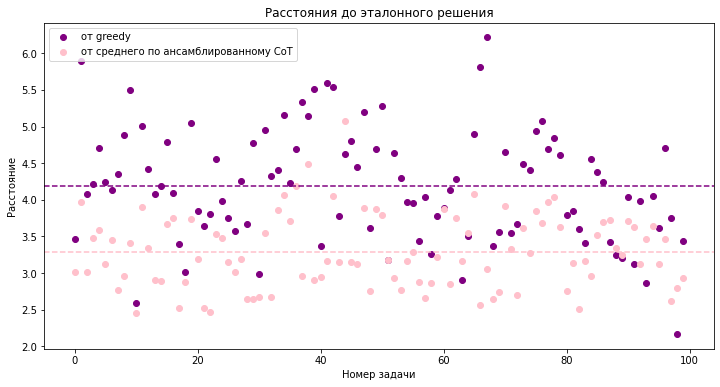

In [180]:
# визуализируем расстояния от greedy векторов до эталонных и от ансамблированных до 
# эталонных для каждой задачи
dists1 = Distances(GREEDY_EMBEDDINGS)
dists2 = Distances(mean_vector(GENERATED_THOUGHTS))

fig = plt.figure(figsize = (12, 6))
ax  = fig.add_subplot(111)

ax.scatter(range(len(dists1)), dists1, c='purple', label='от greedy')
ax.scatter(range(len(dists2)), dists2, c='pink',   label='от среднего по ансамблированному CoT')

ax.axhline(np.mean(dists1), c='purple', linestyle='--')
ax.axhline(np.mean(dists2), c='pink',   linestyle='--')

ax.set_xlabel('Номер задачи')
ax.set_ylabel('Расстояние')
ax.set_title('Расстояния до эталонного решения')

ax.legend()
plt.show()

# Второй способ (случайные примеры):

In [190]:
with open(f'/content/random_greedy.txt', 'r') as f:
  RANDOM_GREEDY_THOUGHTS = f.read().replace('\n', '').split("#")[:-1]

RANDOM_GREEDY_ANSWERS = [Answer_search(thought) for thought in RANDOM_GREEDY_THOUGHTS]

RANDOM_GENERATED_THOUGHTS = []
for i in range(NUMBER_OF_TEST_PROBLEMS):
  with open(f'/content/{i}_random_ensemble.txt', 'r') as f:
    lines = f.read().replace('\n', '')
    lines = lines.split("#")[:-1]
    for i in range(len(lines)):
      if "question:" in lines[i]:
        index = lines[i].index("question:")
        lines[i] = lines[i][:index]

    RANDOM_GENERATED_THOUGHTS.append(lines)

RANDOM_GENERATED_ANSWERS = []
for thoughts in RANDOM_GENERATED_THOUGHTS:
  RANDOM_GENERATED_ANSWERS.append([Answer_search(thought) for thought in thoughts]) 

In [266]:
# если каждый раз случайно выбираются примеры для prompt, 
# используя greedy decoding получили столько правильных ответов:
matching(RANDOM_GREEDY_ANSWERS)

4

In [267]:
# для ансамблированного CoT количество совпадений:
matching(selection(RANDOM_GENERATED_ANSWERS, RANDOM_GENERATED_THOUGHTS))

100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


7

In [268]:
# посчитаем, сколько раз медиана ответов при такой генерации являлась правильным ответом:
median_of_random_answers = [statistics.median(answ) for answ in answers_cleaning(RANDOM_GENERATED_ANSWERS)]
matching(median_of_random_answers)

3

In [269]:
# сколько раз среднее совпало с ответом:
mean_of_random_answers = [int(statistics.mean(answ)) for answ in answers_cleaning(RANDOM_GENERATED_ANSWERS)]
matching(mean_of_random_answers)

0

In [270]:
# количество задач, в которых правильный ответ был сгенерирован
containing(RANDOM_GENERATED_ANSWERS)

25

100%|██████████| 100/100 [00:05<00:00, 19.48it/s]


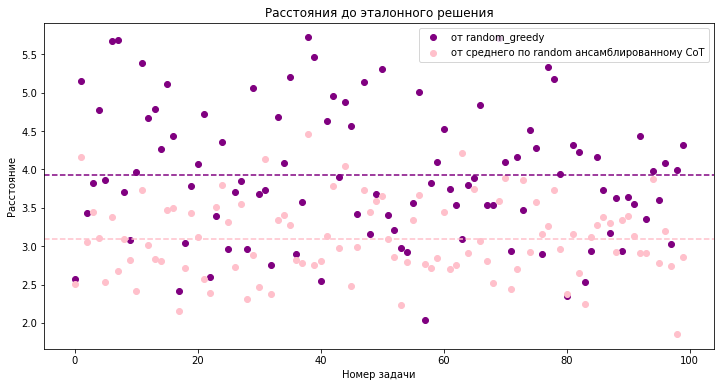

In [199]:
RANDOM_GREEDY_EMBEDDINGS = [sen_to_vec.encode(thought) for thought in RANDOM_GREEDY_THOUGHTS]


dists1 = Distances(RANDOM_GREEDY_EMBEDDINGS)
dists2 = Distances(mean_vector(RANDOM_GENERATED_THOUGHTS))

fig = plt.figure(figsize=(12, 6))
ax  = fig.add_subplot(111)

ax.scatter(range(len(dists1)), dists1, c='purple', label='от random_greedy')
ax.scatter(range(len(dists2)), dists2, c='pink',   label='от среднего по random ансамблированному CoT')

ax.axhline(np.mean(dists1), c='purple', linestyle='--')
ax.axhline(np.mean(dists2), c='pink',   linestyle='--')

ax.set_xlabel('Номер задачи')
ax.set_ylabel('Расстояние')
ax.set_title('Расстояния до эталонного решения')

ax.legend()
plt.show()

# Третий способ (фиксированные примеры с сократовскими вопросами):

In [276]:
with open(f'/content/socratic_greedy.txt', 'r') as f:
  SOCRATIC_GREEDY_THOUGHTS = f.read().replace('\n', '').split("#")[:-1]

SOCRATIC_GREEDY_ANSWERS = [Answer_search(thought) for thought in SOCRATIC_GREEDY_THOUGHTS]

SOCRATIC_GENERATED_THOUGHTS = []
for i in range(NUMBER_OF_TEST_PROBLEMS):
  with open(f'/content/{i}_socratic_ensemble.txt', 'r') as f:
    lines = f.read().replace('\n', '')
    lines = lines.split("#")[:-1]
    for i in range(len(lines)):
      if "question:" in lines[i]:
        index = lines[i].index("question:")
        lines[i] = lines[i][:index]

    SOCRATIC_GENERATED_THOUGHTS.append(lines)

SOCRATIC_GENERATED_ANSWERS = []
for thoughts in SOCRATIC_GENERATED_THOUGHTS:
  SOCRATIC_GENERATED_ANSWERS.append([Answer_search(thought) for thought in thoughts]) 

In [277]:
# сколько раз greedy генерирует правильный ответ с сократовскими вопросами:
matching(SOCRATIC_GREEDY_ANSWERS)

6

In [278]:
# выбираем самые популярные ответы и сравниваем их с настоящими
matching(selection(SOCRATIC_GENERATED_ANSWERS, SOCRATIC_GENERATED_THOUGHTS))

100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


5

In [279]:
# сколько раз медиана совпала с ответом
median_of_random_answers = [statistics.median(answ) for answ in answers_cleaning(SOCRATIC_GENERATED_ANSWERS)]
matching(median_of_random_answers)

2

In [280]:
# сравнение среднего с настоящим ответом
mean_of_random_answers = [int(statistics.mean(answ)) for answ in answers_cleaning(SOCRATIC_GENERATED_ANSWERS)]
matching(mean_of_random_answers)

0

In [281]:
# сколько раз с сократовскими вопросами были в принципе сгенерированы правильные ответы:
containing(SOCRATIC_GENERATED_ANSWERS)

16

100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


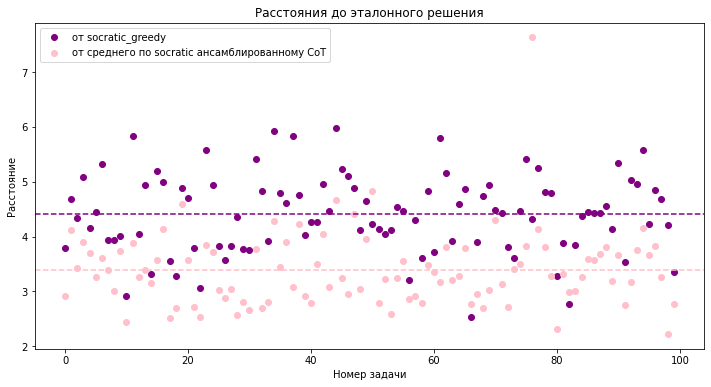

In [282]:
SOCRATIC_GREEDY_EMBEDDINGS = [sen_to_vec.encode(SOCRATIC_GREEDY_THOUGHTS[i])  for i in tqdm(range(NUMBER_OF_TEST_PROBLEMS))]


dists1 = Distances(SOCRATIC_GREEDY_EMBEDDINGS)
dists2 = Distances(mean_vector(SOCRATIC_GENERATED_THOUGHTS))

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

ax.scatter(range(len(dists1)), dists1, c='purple', label='от socratic_greedy')
ax.scatter(range(len(dists2)), dists2, c='pink',   label='от среднего по socratic ансамблированному CoT')

ax.axhline(np.mean(dists1), c='purple', linestyle='--')
ax.axhline(np.mean(dists2), c='pink',   linestyle='--')

ax.set_xlabel('Номер задачи')
ax.set_ylabel('Расстояние')
ax.set_title('Расстояния до эталонного решения')

ax.legend()
plt.show()